In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.spatial.distance import jaccard

In [26]:
########## IMPORTING THE DATASET ##########

### Import our game list dataset ###

df_games = pd.read_csv('data/games.csv')
# We keep only the id and the name of the game, we do not use the others information in this project
df_games = df_games[["app_id", "title"]]
print("We have a list of "+str(len(df_games))+ " games !")

### Add the tags to the df_df_df_datasetsetsetset (tags) ###

# The data is from the following Kaggle dataset : https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam?select=games_metadata.json
# We isolated manually the 'app_id' and the 'tags' from the JSON file putting separators and using Excel to convert it into a CSV file

#Read the input CSV file
df_tags = pd.read_csv('data/game_tags.csv', ';')
# Adding the tags to the initial game list
df_tags = pd.merge(df_tags, df_games, "inner", "app_id")

df_tags.head() # When we want to use our dataset, we call 'df_tags' from now.

We have a list of 48353 games !


C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_20708\2502845285.py:16: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df_tags = pd.read_csv('data/game_tags.csv', ';')


,app_id,tags,title
0,10090,"Zombies,World War II,FPS,Multiplayer,Action,Sh...",Call of Duty: World at War
1,13500,"Action,Adventure,Parkour,Third Person,Great So...",Prince of Persia: Warrior Within™
2,22364,Action,BRINK: Agents of Change
3,113020,"Co-op,Stealth,Indie,Heist,Local Co-Op,Strategy...",Monaco: What's Yours Is Mine
4,226560,"Zombies,Adventure,Survival,Action,Third Person...",Escape Dead Island


In [27]:
########## PRE-PROCESSING OF THE DATA ##########

# If the final file of the preprocessing part exists, skip this part
# The preprocessing takes around 10min and must be done only once

execute_preprocessing = True

if (os.path.isfile("data/matrix_game_tags.csv")):
    execute_preprocessing = False

print(execute_preprocessing)

False


In [28]:
if (execute_preprocessing) :

    ### PRE-PROCESSING (part 1) ###
    # -> Extract the list of unique game tags

    df_tags_string = df_tags['tags'].str.split(',')
    df_tags_list = df_tags_string.explode().drop_duplicates()
    list_tags = df_tags_list.tolist()

    #Save the result in a file (optional)
    with open('data/unique_tags_list.txt', 'w') as output_file:
            for tag in list_tags:
                output_file.write(str(tag) + '\n')

    ### PRE-PROCESSING (part 2) ###
    # -> Create the game matrix (filled with 0) where each row is a game and the colomns are all the unique game tags (matrix size~ 47456 x 442)

    game_tag_matrix = pd.DataFrame("0", index=df_tags['app_id'], columns=list_tags)

    ### PRE-PROCESSING (part 3) ###
    # -> For each games, read its tags, and put a 1 in the corresponding colomn

    for index, row in df_tags.iterrows(): 
        app_id = row["app_id"]
        app_tags = str(row["tags"]).split(',')
        for tag in app_tags:
            game_tag_matrix.loc[app_id, tag] = "1"

    game_tag_matrix = game_tag_matrix.drop(["nan"], axis=1) # Value for games that have to tags in the dataset

    game_tag_matrix.to_csv('data/matrix_game_tags.csv', encoding='utf-8')
    #=> We can now use the 'game_tag_matrix' for the dimentionality reduction !

else:
     print("The preprocessing have been skipped: The result file (matrix_game_tags.csv) already exist.\n If you want to regenerate the file, delete it and re-execute the code.")

The preprocessing have been skipped: The result file (matrix_game_tags.csv) already exist.
 If you want to regenerate the file, delete it and re-execute the code.


In [29]:
##### TRYING TO IMPLEMENT THE K-MEANS ALGORITHM FOR THE DIMENTIONALITY REDUCTION #####
#=> This is only for archive, we enventually did not use it.

def kmeans(df_dataset, k, max_iters=100):
    # Initialize centroids randomly
    centroids = df_dataset[np.random.choice(df_dataset.shape[0], k, replace=False), :]

    for i in range(max_iters):
        # Calculate distances between data points and centroids
        distances = np.linalg.norm(df_dataset[:, np.newaxis] - centroids, axis=2)
        cluster_assignments = np.argmin(distances, axis=1)
        new_centroids = np.array([df_dataset[cluster_assignments == i].mean(axis=0) for i in range(k)])

        # Check for convergence
        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    return cluster_assignments

# df_game_tags_binary = pd.read_csv('data/game_tags_binary.csv', index_col='Unnamed: 0')
# df_game_tags_binary.head()
# # # Convert DataFrame to NumPy array
# data = df_game_tags_binary.to_numpy()

# # Apply K-means clustering
# k = 2
# cluster_assignments = kmeans(data, k)

# # Replace the original features with the cluster assignments
# reduced_data = np.zeros_like(data)
# reduced_data[:, 0] = cluster_assignments

# # Convert the reduced data back to a DataFrame
# reduced_df = pd.DataFrame(reduced_data, index=df_game_tags_binary.index)

# # Save the reduced DataFrame to a CSV file
# reduced_df.to_csv('reduced_game_tags_kmeans.csv')

In [30]:
##### IMPLEMENTING 'SVD' FOR THE DIMENTIONALITY REDUCTION #####

def power_iteration(A, num_iter=1000):
    b = np.random.rand(A.shape[1])

    for _ in range(num_iter):
        b = np.dot(A, b)
        b = b / np.linalg.norm(b)

    return b

# Decompose the matrix in three matrices: U (left singular vector), S (singular values), and Vt (right singular vector)
def svd_matrix_decompostion(centered_dataset, num_concepts, num_iter=1000):
    U = np.zeros((centered_dataset.shape[0], num_concepts))
    S = np.zeros(num_concepts)
    Vt = np.zeros((num_concepts, centered_dataset.shape[1]))

    for i in range(num_concepts):
        B = np.dot(centered_dataset.T, centered_dataset)
        v = power_iteration(B, num_iter)
        Vt[i, :] = v

        singular_value = np.sqrt(np.dot(v, np.dot(B, v)))
        S[i] = singular_value

        u = np.dot(centered_dataset, v) / singular_value
        U[:, i] = u

        centered_dataset = centered_dataset - singular_value * np.outer(u, v)

    return U, S, Vt

# Apply the dimensionality reduction by selecting the top-k singular values
# and singular vectors to reduce the dimensionality and reduce the number of columns
def svd_reduction(df_game_tags_binary, num_concepts, std_multiplier):
    
    # Center the data values to obtain better results
    input_dataset = df_game_tags_binary.to_numpy()
    column_mean = np.mean(input_dataset, axis=0)
    centered_dataset = input_dataset - column_mean

    U, S, Vt = svd_matrix_decompostion(centered_dataset, num_concepts)
    U_reduced = U[:, :num_concepts]
    S_reduced = np.diag(S[:num_concepts])

    svd_dataset = np.dot(U_reduced, S_reduced)

    # Calculate and apply the standard deviation of each column
    std_devs = np.std(svd_dataset, axis=0)
    for i in range(svd_dataset.shape[1]):
        threshold = std_multiplier * std_devs[i]
        svd_dataset[:, i] = np.where(np.abs(svd_dataset[:, i]) > threshold, 1, 0).astype(np.int8)

    columns_array = np.array(df_game_tags_binary.columns)
    top_tags = columns_array[np.argsort(-np.abs(Vt[:num_concepts, :]))[:, :num_concepts]]
    column_names = [', '.join(tags) for tags in top_tags]

    df_svd = pd.DataFrame(svd_dataset, index=df_game_tags_binary.index, columns=column_names)

    return df_svd


def find_similar_games(df_svd, input_app_id, threshold):
    
    similar_games = []
    input_vector = df_svd.loc[df_svd['app_id'] == input_app_id].drop('app_id', axis=1).values[0]
    
    for index, row in df_svd.iterrows():
        compare_app_id = row['app_id']
        compare_vector = row.drop('app_id')
        
        # Compute the Jaccard distance: jaccard(v1, v2) = 1 - |v1 ∩ v2|/|v1 ∪ v2|
        j_distance = jaccard(input_vector, compare_vector)
        
        if j_distance <= threshold: # We accept only the games that have a small jaccard distance (limit defined by the threshold)
            similar_games.append(compare_app_id)
    
    return similar_games



##### VISUALIZATION FUNCTIONS #####


# This methods allows us to vizualise the number of ones after applying the SVD, 
# using different standard divisations as threshold for converting the singular values matrix into a binary matrix.
def compare_std_deviations(df_game_tags_binary, num_concepts):
    counts_std = {}

    # For 1st, 2nd, and 3rd standard deviations
    for std_multiplier in range(1, 3+1):

        df_svd = svd_reduction(df_game_tags_binary, num_concepts, std_multiplier)
        
        # We count the number of zeros and non-zeros in the result
        counts = (df_svd == 0).sum().sum(), (df_svd != 0).sum().sum()
        counts_std[std_multiplier] = counts

    # Create a plot to diplay the results
    counts_df = pd.DataFrame(counts_std, index=['Zeros', 'Non-zeros'])    
    counts_df.T.plot(kind='bar', stacked=True)
    plt.xlabel('Standard deviation multiplier')
    plt.ylabel('Count')
    plt.title('Number of zeros and non-zeros for different standard deviation multipliers')
    plt.show()


# We use this method to analyse what is the best number of tags to merge into one concept.
# For this, we do a visualisation of the number of similar games for power of 2 concepts in a concept.
# Note that this vizualisation applies for only the input games with all the determined parameters
def compare_concepts(df_game_tags_binary, df_tags, app_id, threshold, std_multiplier):
    component_counts = []
    num_similar_games = []
    max_power = 10

    for i in range(1, max_power+1):
        num_concepts = 10 * i

        # Appying the SVD and the find the similar games with number of concepts
        reduced_df = svd_reduction(df_game_tags_binary, num_concepts, std_multiplier)
        reduced_df = reduced_df.join(df_tags)
        similar_games = find_similar_games(reduced_df, app_id, threshold)

        component_counts.append(num_concepts)
        num_similar_games.append(len(similar_games))

    # The green lines represent the goal values
    plt.axhline(y=5, color='green',  linestyle='--')
    plt.axhline(y=15, color='green', linestyle='--')  

    plt.ylim(bottom=0, top=50)
    plt.xlim(left=0, right=100)

    plt.plot(component_counts, num_similar_games)
    plt.xlabel('Number of concepts')
    plt.ylabel('Number of Similar Games')
    plt.title('Number of Similar Games for Different Numbers of concepts')
    plt.show()

# We use this method to observe the impact of threshold on the number of recommended games.
# It apllies for the current selscted games with the defined number of concepts
def compare_threshold(df_svd, app_id, num_concepts):
    threshold_counts = []
    num_similar_games = []
    max_power = 10

    for i in range(0, max_power+1):
        threshold = 0.1 * i

        # Appying the SVD and the find the similar games with number of concepts
        similar_games = find_similar_games(df_svd, app_id, threshold)

        # Add the number of similar games to the list
        threshold_counts.append(threshold)
        num_similar_games.append(len(similar_games))
       
    # The green lines represent the goal values
    plt.axhline(y=5, color='green',  linestyle='--')
    plt.axhline(y=15, color='green', linestyle='--')  

    plt.ylim(bottom=0, top=100)
    plt.xlim(left=0, right=1)

    plt.plot(threshold_counts, num_similar_games)
    plt.xlabel('Threshold')
    plt.ylabel('Number of Similar Games')
    plt.title('Number of Similar Games for Different Jaccard distance Threshold')
    plt.show()

In [31]:
########## EXECUTION OF DIMENSIONALITY REDUCTION USING SVD ##########

### Parameters of the SVD ###
num_concepts = 50 # From our visualisation
std_multiplier = 2 # From our visualisation, we take the 2nd standard devation to keep the stonger corealtion between game and concept, but still have a correct amount of ones

# We load the preprocessed matrix
df_game_tags_binary = pd.read_csv('data/matrix_game_tags.csv')
df_app_id = df_game_tags_binary[['app_id']] #We save the app_id column...
df_game_tags_binary = df_game_tags_binary.drop(['app_id'], axis=1) #... and then remove it for the SVD process
print("Numbers of tags :")
print(len(df_game_tags_binary.columns))

df_svd = svd_reduction(df_game_tags_binary, num_concepts, std_multiplier)

# We add the app_id column again in as first column
# We can do this because the games stay in the same order
df_svd = df_svd.join(df_app_id)
df_svd = df_svd[['app_id'] + [col for col in df_svd.columns if col != 'app_id']]

# Save the result in csv file
df_svd.to_csv('results/reduced_game_tags_svd.csv')

Numbers of tags :
442


In [32]:
### Parameters of the recommender system ###

input_app_id = 504230 # Go in games.csv, and pick an app_id to compute its similar games
threshold = 0.6
threshold_step = 0.05
game_recommendation_limit = 15
game_recommendation_requirement = 5

In [33]:
### WHAT THRESHOLD TO PICK TO CONVERT THE SINGULAR VALUES MATRIX INTO BINARY MATRIX ###

execute_std_visualisation = False # Takes less than a minute
if (execute_std_visualisation):
    compare_std_deviations(df_game_tags_binary, num_concepts)

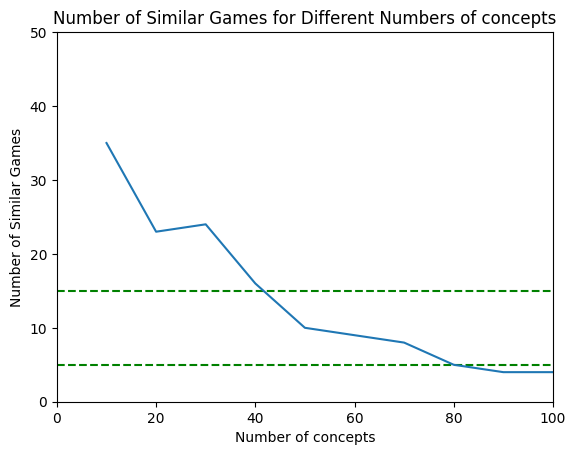

In [34]:
### HOW MANY TAGS MUST WE MERGE INTO ONE CONCEPT ? ###

execute_concepts_visualisation = True # Takes around 15 min
if (execute_concepts_visualisation):
    compare_concepts(df_game_tags_binary, df_tags, input_app_id, threshold, std_multiplier)

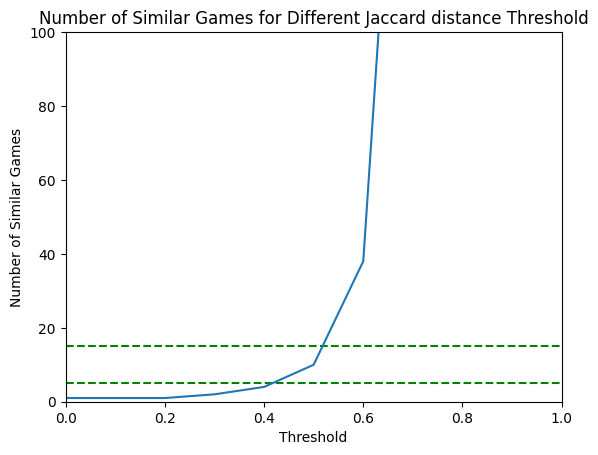

In [35]:
### WHAT IS THE CORRECT THRESHOLD WITH THESE PARAMETERS ? ###

execute_threshold_visualisation = True # Takes around 6 min with 50 concepts
if (execute_threshold_visualisation):
    compare_threshold(df_svd, input_app_id, num_concepts)

In [36]:
### COMPUTING THE RECOMMENDATIONS ###

similar_games = []
while ((len(similar_games) > game_recommendation_limit) or (len(similar_games) < game_recommendation_requirement)):
    
    similar_games = find_similar_games(df_svd, input_app_id, threshold)
    similar_games.remove(input_app_id)

    # Modify the theshold if the results are not satisfying
    if (len(similar_games) < game_recommendation_requirement):
        threshold = round(threshold + threshold_step, 2)
        print("Found not enough games ("+str(len(similar_games))+") with the current threshold. Retrying with a higher threshold = "+str(threshold))
    elif (len(similar_games) > game_recommendation_limit):
        threshold = round(threshold - threshold_step, 2)
        print("Found too much games ("+str(len(similar_games))+") with the current threshold. Retrying with a smaller threshold = "+str(threshold))
    else :
        print("Found "+ str(len(similar_games))+ " similar games with threshold = " + str(threshold) )

    if (threshold == 0 or threshold == 1):
        print("Could not find any good association with the selected game.")
        print("The probable causes are:")
        print(" 1. The number of concepts created might be too low, try again by increasing the 'num_concepts' values in the SVD parameters (cell 7).")
        print(" 2. The game you selected does not have enough tags references. Please select another game.")
        print("\nTip : You can run the visualization to get a better idea of what is happening. /!\ It takes some time.")
        break


if (not(threshold == 0 or threshold == 1)):
    # Retrieve the titles based on the app_ids
    input_game = title = df_tags.loc[df_tags['app_id'] == input_app_id, 'title'].values[0]
    output_games_list = df_tags.loc[df_tags['app_id'].isin(similar_games), 'title'].tolist()

    # Display the results
    print("Because you played \"" + input_game + "\", we recommend you the following games :")
    for recommended_game in output_games_list:
        print("- "+ recommended_game)

Found too much games (37) with the current threshold. Retrying with a smaller threshold = 0.55
Found 11 similar games with threshold = 0.55
Because you played "Celeste", we recommend you the following games :
- Sydney Hunter and the Curse of the Mayan
- Aeon Drive
- Judgment: Apocalypse Survival Simulation
- Freedom Planet
- Cave Story+
- VVVVVV
- Finding Paradise
- DOOMED
- Welcome to Bummertown
- Lorera
- You Have to Win the Game
